In [10]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import random

In [2]:
import re
# pip install nltk
import nltk
from collections import defaultdict

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bartekb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bartekb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
spotify_df = pd.read_csv('../Data/spotify_modelling.csv')
spotify_df.head(10) 

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,You Proof,Morgan Wallen,1,2022,5,13,2128,9,367814306,37,...,120,A,Major,73,64,85,25,0,61,3
1,Adore You,Harry Styles,1,2019,12,6,13454,1,1439191367,246,...,99,G#,Major,68,57,77,2,0,10,5
2,Piï¿½ï¿½man Deï¿,"Semicenk, Doï¿½ï¿½u",2,2023,6,2,185,3,43522589,5,...,98,A#,Minor,73,45,62,28,0,13,13
3,CORAZï¿½ï¿½N VA,Maria Becerra,1,2023,6,22,370,20,43857627,12,...,98,C#,Major,68,40,79,33,0,30,6
4,Those Eyes,New West,1,2019,5,10,1507,14,411747614,24,...,120,E,Major,60,24,35,73,0,31,3
5,Crown,Kendrick Lamar,1,2022,5,13,1493,0,42485571,2,...,170,C#,Minor,37,14,24,80,0,11,4
6,HUMBLE.,Kendrick Lamar,1,2017,3,30,33206,1,1929770265,284,...,150,C#,Minor,91,42,60,0,0,9,12
7,I Know - PR1SVX Edit,"Kanii, PR1ISVX",2,2023,3,24,407,0,77377503,16,...,134,B,Minor,67,11,76,8,47,30,7
8,Levitating (feat. DaBaby),"Dua Lipa, DaBaby",2,2020,3,27,15894,8,1802514301,198,...,103,F#,Minor,70,92,83,1,0,7,6
9,DOGTOOTH,"Tyler, The Creator",2,2023,3,27,1479,0,80758350,23,...,78,G#,Major,71,80,65,51,0,22,32


# 1. Feature engineering

## TODO
- ogarnąć to jak jest np trzech artystów po przecinku
- brakujące wartości w key i w in_shazam_charts
- jakaś standaryzacja??? box-cox??? to się stosuje w clusteringu???
- encoding???
- usunięcie części kolumn???
- nowe kolumny
- pipeline do zautomatyzowania

In [ ]:
# handle incorrect values
spotify_df.at[497, 'streams'] = None
spotify_df['streams'] = spotify_df['streams'].astype(float)
spotify_df['in_deezer_playlists'] = spotify_df['in_deezer_playlists'].str.replace(',', '', regex=False)
spotify_df['in_deezer_playlists'] = spotify_df['in_deezer_playlists'].astype(int)
spotify_df['in_shazam_charts'] = spotify_df['in_shazam_charts'].str.replace(',', '', regex=False)
spotify_df['in_shazam_charts'] = spotify_df['in_shazam_charts'].astype(float)
print(spotify_df['streams'].mean())
spotify_df['streams'].fillna(524376116,inplace=True)

## Categorical variables

In [54]:
numeric = ['in_shazam_charts','in_deezer_charts','in_deezer_playlists','in_apple_charts','in_apple_playlists','streams','in_spotify_charts','in_spotify_playlists','bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
categorical = list(set(spotify_df.columns) - set(numeric))
categorical

['released_month',
 'artist_count',
 'mode',
 'artist(s)_name',
 'released_year',
 'track_name',
 'key',
 'released_day']

Plan:
- ordinal encoding for **key** column
- binary encode **mode**
- try cyclical encoding of **released_month** and **released_day**
- try grouping and ordinal encoding **released_year**
- decide about **artist(s)_name** and **track_name**



key 

We use ordinal encoding for the 'key' column because musical keys have a natural order based on their pitch, which is important for preserving the inherent relationships between them in musical theory. The chosen order reflects the sequence of keys in a chromatic scale, ensuring that the encoding respects the progression from one key to the next in terms of pitch.

In [55]:
spotify_df.key.unique()

array(['A', 'G#', 'A#', 'C#', 'E', 'B', 'F#', 'D', nan, 'F', 'D#', 'G'],
      dtype=object)

In [19]:

key_order = [
    'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', np.nan
]
ordinal_encoder = OrdinalEncoder(categories=[key_order], handle_unknown='use_encoded_value', unknown_value=-1)
spotify_df['key'] = spotify_df['key'].astype(object)
encoded_keys = ordinal_encoder.fit_transform(spotify_df[['key']])
spotify_df['key'] = encoded_keys
#fill missing valeus with most common value
spotify_df['key'].fillna(-1, inplace=True)


mode

In [60]:
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['Major', 'Minor'])
spotify_df['mode'] = label_encoder.fit_transform(spotify_df['mode'])

released_month and released_day

In [62]:
spotify_df['month_sin'] = np.sin(2 * np.pi * spotify_df['released_month'] / 12)

spotify_df['day_sin'] = np.sin(2 * np.pi * spotify_df['released_day'] / 31)

released_year

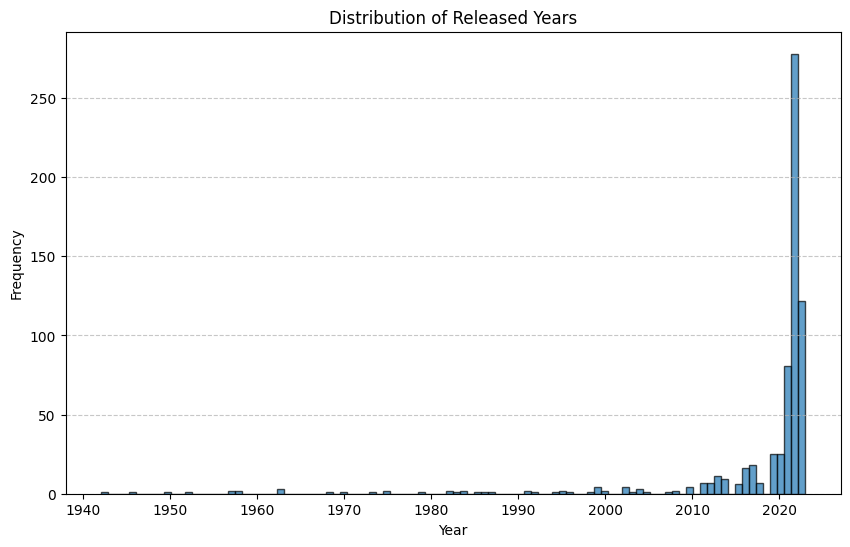

2023
1942


In [73]:
plt.figure(figsize=(10, 6))
plt.hist(spotify_df['released_year'],bins=100, edgecolor='k', alpha=0.7)
plt.title('Distribution of Released Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print(max(spotify_df.released_year))
print(min(spotify_df.released_year))

considering histogram above ands trends in music, we will try grouping released_year in intervals:
- [1942 , 1989]
- [1990 , 1999]
- [2000 , 2010]
- [2011 , 2015]
- [2016, 2019]
- 2020
- 2021
- 2022
- 2023

In [74]:
bins = [1942, 1989, 1999, 2010, 2015, 2019, 2020, 2021, 2022, 2023]
labels = ['1942-1989', '1990-1999', '2000-2010', '2011-2015', '2016-2019', '2020', '2021', '2022', '2023']

spotify_df['year_group'] = pd.cut(spotify_df['released_year'], bins=bins, labels=labels, right=True, include_lowest=True)

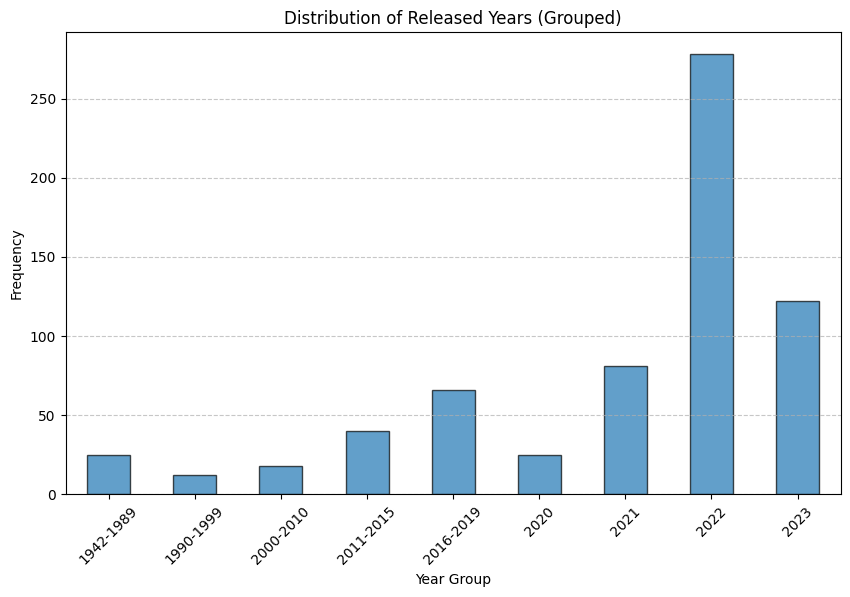

In [76]:
plt.figure(figsize=(10, 6))
spotify_df['year_group'].value_counts().sort_index().plot(kind='bar', edgecolor='k', alpha=0.7)
plt.title('Distribution of Released Years (Grouped)')
plt.xlabel('Year Group')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

In [77]:
ordinal_mapping = {label: idx for idx, label in enumerate(labels)}

spotify_df['year_group_encoded'] = spotify_df['year_group'].map(ordinal_mapping)


Track Name

By simply encoding this variable we will not achieve anything, since almost all songs have different title. We can try to extract keywords, determining what the song is about and label it that way


idk czy to ma sens ale mozna pokazac i tak, nawet jak tego w modelu nie zastosujemy

In [125]:
def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'\W+', ' ', text) 
    tokens = word_tokenize(text) 
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

spotify_df['processed_track_name'] = spotify_df['track_name'].apply(preprocess_text)

In [119]:
# keywords and song topics generated by chatgpt
topics = {
    'love': ['love', 'romance', 'heart', 'passion', 'affection', 'relationship', 'sweetheart', 'devotion', 'together', 'kiss', 'couples', 'embrace', 'intimacy', 'wedding', 'romantic', 'admiration', 'adoration', 'infatuation', 'commitment', 'tenderness', 'butterflies', 'endearment', 'cherish', 'loyalty', 'soulmate', 'chemistry', 'courtship', 'truelove', 'warmth'],
    'party': ['party', 'dance', 'club', 'celebration', 'night', 'fun', 'music', 'drink', 'friends', 'good time', 'festive', 'cheer', 'groove', 'get-together', 'rave', 'excitement', 'festivity', 'socialize', 'entertainment', 'vibrant', 'fest', 'revelry', 'beats', 'livelihood', 'festive', 'boogie', 'festivity', 'festival', 'soiree'],
    'sad': ['sad', 'tears', 'cry', 'heartbreak', 'pain', 'lonely', 'hurt', 'grief', 'sorrow', 'loss', 'melancholy', 'despair', 'depression', 'mourning', 'suffering', 'anguish', 'desolation', 'regret', 'misery', 'despondency', 'heartache', 'anguish', 'downhearted', 'bereavement', 'wretched', 'woeful', 'pained', 'lament', 'dejected'],
    'nostalgia': ['memory', 'old', 'past', 'nostalgia', 'remember', 'youth', 'reminisce', 'nostalgic', 'childhood', 'memories', 'retro', 'vintage', 'recollection', 'flashback', 'sentimental', 'heritage', 'heritage', 'retrospect', 'antique', 'reminiscence', 'recapture', 'revisit', 'reflective', 'yesteryears', 'timeless', 'nostalgic', 'nostalgic', 'reminiscing', 'revive'],
    'adventure': ['road', 'travel', 'journey', 'explore', 'discovery', 'wanderlust', 'adventure', 'expedition', 'voyage', 'explore', 'explorer', 'quest', 'odyssey', 'wandering', 'discover', 'excursion', 'quest', 'wander', 'pioneering', 'trek', 'jaunt', 'sojourn', 'venture', 'venture', 'traverse', 'roam', 'peripatetic', 'roving', 'excursion'],
    'inspirational': ['inspiration', 'motivation', 'uplifting', 'hope', 'encouragement', 'empowerment', 'dream', 'aspiration', 'positivity', 'strength', 'inspire', 'encourage', 'empower', 'perseverance', 'achievement', 'insightful', 'encouraging', 'empowering', 'inspirational', 'uplift', 'invigorate', 'revitalize', 'energize', 'empowering', 'motivate', 'upliftment', 'optimistic', 'enthusiastic', 'motivated'],
    'nature': ['nature', 'earth', 'sky', 'ocean', 'forest', 'mountain', 'wildlife', 'scenery', 'landscape', 'environment', 'natural', 'outdoors', 'ecology', 'wilderness', 'flora', 'fauna', 'terrain', 'scenic', 'serene', 'biodiversity', 'countryside', 'greenery', 'botanical', 'biological', 'zenith', 'wild', 'lush', 'serenity'],
    'reflection': ['reflection', 'contemplation', 'introspection', 'meditation', 'thought', 'ponder', 'ruminate', 'consider', 'analyze', 'evaluate', 'philosophy', 'self-awareness', 'introspective', 'pondering', 'self-reflection', 'thoughtful', 'contemplative', 'analytical', 'introspective', 'deliberate', 'self-examination', 'speculate', 'mull', 'think', 'deliberation', 'reflection', 'introspection'],
    'dream': ['dream', 'fantasy', 'imagination', 'wish', 'vision', 'desire', 'goal', 'ideal', 'ambition', 'fantasize', 'daydream', 'whimsical', 'fanciful', 'dreamer', 'dreamland', 'visionary', 'creative', 'imaginative', 'idealistic', 'aspiration', 'dreamlike', 'dreamworld', 'dreamer', 'dreamy', 'dreamscape', 'imaginative', 'vision', 'utopia'],
    'hope': ['hope', 'optimism', 'faith', 'belief', 'trust', 'confidence', 'promise', 'reassurance', 'expectation', 'anticipation', 'optimistic', 'faithful', 'reliable', 'hopeful', 'assurance', 'reliance', 'positive', 'faith', 'expectant', 'confidence', 'assurance', 'reassure', 'hopefulness', 'positive', 'assure', 'faith', 'optimism', 'confidence']
}


In [126]:
def determine_topic(tokens):
    topic_scores = {topic: 0 for topic in topics}
    for word in tokens:
        for topic, keywords in topics.items():
            if word in keywords:
                topic_scores[topic] += 1
    max_score = max(topic_scores.values())
    if max_score == 0:
        return 'other'
    else:
        return max(topic_scores, key=topic_scores.get)

spotify_df['topic'] = spotify_df['processed_track_name'].apply(determine_topic)

artist names - the idea to solve the problem is to assign song to the most popular collaborator. Encoding this variable is another problem because there are dużo of unique values, so one hot encoding is srednie, and there is no ordinality in this variable so label encoding tez jest srednie. We can try to grop this variable by popularity of most popular author and label encode it. 

In [3]:
# function to make dictionary of artists popularity by avg value of streams column. This step should be done on modelling dataset 
# and this dictionary should be used on validating dataset
def split_artists(df, artist_col='artist(s)_name'):
    df_expanded = df.copy()
    df_expanded[artist_col] = df_expanded[artist_col].str.split(',')
    df_expanded = df_expanded.explode(artist_col)
    df_expanded[artist_col] = df_expanded[artist_col].str.lower().str.replace(' ', '')
    return df_expanded.reset_index(drop=True)
def calculate_mean_streams(df, artist_col='artist(s)_name', streams_col='streams'):
    mean_streams = df.groupby(artist_col)[streams_col].mean()
    return mean_streams.to_dict()

In [43]:
popularity = calculate_mean_streams(split_artists(spotify_df))

In [51]:
popularity

{'': 0.052706711937782855,
 '(g)i-dle': 0.03747013668160521,
 '070shake': 0.1005798328007401,
 '21savage': 0.08165999079724105,
 '24kgoldn': 0.47701895330933003,
 '2pac': 0.1626345799761389,
 '347aidan': 0.045148272881918014,
 '50cent': 0.33760169210318797,
 'a$aprocky': 0.026437225737482067,
 'abhirhathi': 0.06888268687518716,
 'aboogiewitdahoodie': 0.03067287255750104,
 'acraze': 0.18940698500197078,
 'adele': 0.40405226768795355,
 'aerosmith': 0.23538928446582696,
 'agroplay': 0.06562699533836792,
 'agustd': 0.03334908615264132,
 'aitch': 0.04104394159853191,
 'ak4:20': 0.03322869484076873,
 'alecbenjamin': 0.385842117076606,
 'alejo': 0.07663145861091096,
 'alesso': 0.06368904353600491,
 'aliciakeys': 0.030105676298595143,
 'alisethi': 0.07978773010252249,
 'alvarodiaz': 0.05888092837759374,
 'amaarae': 0.09938480828115229,
 'amandareifer': 0.06662332741495862,
 'amitabhbhattacharya': 0.10290318955722665,
 'anacastela': 0.06447832340646033,
 'anderson.paak': 0.21044325133753233,
 '

In [4]:
#function to assign song to most popular artist 
def process_artists(df, artist_avg_streams, artist_col='artist(s)_name', artist_count_col='artist_count'):
    def get_top_artist(artists, artist_avg_streams):
        artists = [artist.lower().replace(' ', '') for artist in artists]
        valid_artists = [artist for artist in artists if artist in artist_avg_streams]
        if valid_artists:
            top_artist = max(valid_artists, key=lambda artist: artist_avg_streams[artist])
        else:
            top_artist = random.choice(artists)
        return top_artist
    processed_df = df.copy()
    for i, row in processed_df.iterrows():
        artists = row[artist_col].split(',')
        top_artist = get_top_artist(artists, artist_avg_streams)
        processed_df.at[i, artist_col] = top_artist
            
    return processed_df

In [74]:
spotify_df = process_artists(spotify_df,popularity)
spotify_df[spotify_df['artist(s)_name'].str.contains('kanye', case=False, na=False)]

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,artist_popularity
27,Heartless,kanyewest,1,2008,1,1,0.330509,0.231293,0.249233,0.163121,10.0,Minor,0.777778,0.666667,0.636364,0.051546,0.0,0.234043,0.210526,3
349,City of Gods,kanyewest,3,2022,2,11,0.039060,0.000000,0.030106,0.581560,8.0,Minor,0.333333,0.494624,0.806818,0.103093,0.0,0.308511,0.631579,1
618,Hot Shit (feat. Ye & Lil Durk),kanyewest,3,2022,7,1,0.029697,0.000000,0.024118,0.652482,9.0,Major,0.902778,0.516129,0.681818,0.000000,0.0,0.053191,0.368421,1


In [60]:
print(len(df2['artist(s)_name'].unique()))
print(len(spotify_df['artist(s)_name'].unique()))

342
477


In [5]:
# function to group artists of songs by popularity
def assign_artist_popularity(df, artist_avg_streams, artist_col='artist(s)_name'):
    # Calculate the four quantiles for the dictionary values
    quantiles = pd.qcut(list(artist_avg_streams.values()), 4, labels=False, retbins=True)[1]
    
    # Function to assign popularity based on quantiles
    def get_popularity(artist, artist_avg_streams, quantiles):
        artist = artist.lower().replace(' ', '')
        avg_streams = artist_avg_streams.get(artist, None)
        if avg_streams is not None:
            if avg_streams <= quantiles[1]:
                return 1
            elif avg_streams <= quantiles[2]:
                return 2
            elif avg_streams <= quantiles[3]:
                return 3
            else:
                return 4
        else:
            return 1  # Assign 1 if artist is not in the dictionary
    
    # Create a new column 'artist_popularity' and assign values based on quantiles
    df['artist_popularity'] = df[artist_col].apply(lambda artist: get_popularity(artist, artist_avg_streams, quantiles))
    
    return df

In [77]:
assign_artist_popularity(spotify_df,popularity)
spotify_df[['artist(s)_name','artist_popularity']]

,artist(s)_name,artist_popularity
0,morganwallen,1
1,harrystyles,4
2,semicenk,1
3,mariabecerra,3
4,newwest,3
...,...,...
662,pnau,4
663,taylorswift,3
664,keisyalevronka,2
665,hotelugly,2


# Numeric variables

In [130]:
numeric

['in_shazam_charts',
 'in_deezer_charts',
 'in_deezer_playlists',
 'in_apple_charts',
 'in_apple_playlists',
 'streams',
 'in_spotify_charts',
 'in_spotify_playlists',
 'bpm',
 'danceability_%',
 'valence_%',
 'energy_%',
 'acousticness_%',
 'instrumentalness_%',
 'liveness_%',
 'speechiness_%']

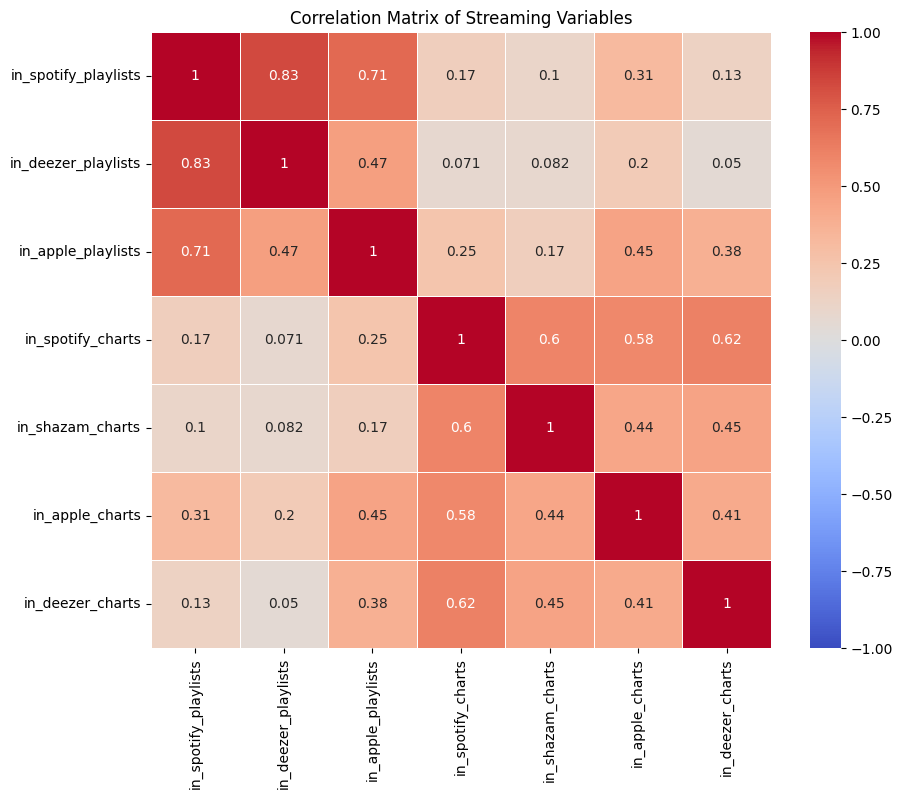

In [14]:
correlation_matrix = spotify_df[['in_spotify_playlists', 'in_deezer_playlists', 'in_apple_playlists','in_spotify_charts','in_shazam_charts', 'in_apple_charts', 'in_deezer_charts']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5,vmin=-1,vmax=1)
plt.title('Correlation Matrix of Streaming Variables')
plt.show()

variables: in_spotify_charts in_apple_charts and in_deezer_charts are strongly correlated so we decide to leave only in_spotify_charts.
from in_apple_playlists and in_apple_playlists we decide to delete in_apple_playlists

In [29]:
spotify_df.drop(columns=['in_apple_charts' ,'in_shazam_charts', 'in_deezer_charts','in_apple_playlists','in_deezer_playlists'],axis='columns',inplace=True)

normalize other numeric variables

In [30]:
cols_to_normalize =['streams',
 'in_spotify_charts',
 'in_spotify_playlists',
 'bpm',
 'danceability_%',
 'valence_%',
 'energy_%',
 'acousticness_%',
 'instrumentalness_%',
 'liveness_%',
 'speechiness_%']


scaler = MinMaxScaler()
spotify_df[cols_to_normalize] = scaler.fit_transform(spotify_df[cols_to_normalize])

## creating Pipeline to automate preprocessing

In [32]:
def preprocess_data(df):
    
    # handle incorrect data ande missing values
    non_numeric_indexes = df[df['streams'].astype(str).str.contains('[a-zA-Z]')].index
    df.loc[non_numeric_indexes, 'streams'] = None
    df['streams'].fillna(524376116,inplace=True)
    df['streams'] = df['streams'].astype(float)
    df['in_deezer_playlists'] = df['in_deezer_playlists'].str.replace(',', '', regex=False)
    df['in_deezer_playlists'] = df['in_deezer_playlists'].astype(int)
    df['in_shazam_charts'] = df['in_shazam_charts'].str.replace(',', '', regex=False)
    df['in_shazam_charts'] = df['in_shazam_charts'].astype(float)
    df['key'].fillna('G',inplace=True)

    # encode categorical variables
    key_order = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', np.nan]
    ordinal_encoder = OrdinalEncoder(categories=[key_order], handle_unknown='use_encoded_value', unknown_value=-1)
    df['key'] = df['key'].astype(object)
    encoded_keys = ordinal_encoder.fit_transform(df[['key']])
    df['key'] = encoded_keys

    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(['Major', 'Minor'])
    df['mode'] = label_encoder.fit_transform(df['mode'])

    df['month_sin'] = np.sin(2 * np.pi * df['released_month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['released_day'] / 31)

    bins = [-float('inf'), 1989, 1999, 2010, 2015, 2019, 2020, 2021, 2022, 2023]
    labels = ['1942-1989', '1990-1999', '2000-2010', '2011-2015', '2016-2019', '2020', '2021', '2022', '2023']
    df['year_group'] = pd.cut(df['released_year'], bins=bins, labels=labels, right=True, include_lowest=True)
    ordinal_mapping = {label: idx for idx, label in enumerate(labels)}
    df['year_group_encoded'] = df['year_group'].map(ordinal_mapping)

    # as for now we will not use 'track name' column

    #assign artist popularity
    df2 = pd.read_csv('../Data/spotify_modelling.csv')
    non_numeric_indexes = df2[df2['streams'].astype(str).str.contains('[a-zA-Z]')].index
    df2.loc[non_numeric_indexes, 'streams'] = None
    df2['streams'].fillna(524376116,inplace=True)
    df2['streams'] = df2['streams'].astype(float)
    pop = calculate_mean_streams(split_artists(df2))
    df = process_artists(df,pop)
    df = assign_artist_popularity(df,pop)

    # Normalize numeric columns
    cols_to_normalize =['streams','in_spotify_charts','in_spotify_playlists','bpm','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%']
    scaler = MinMaxScaler()
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

    # drop unnecessary columns
    df.drop(columns=['year_group','in_apple_charts' ,'in_shazam_charts', 'in_deezer_charts','in_apple_playlists','in_deezer_playlists','artist(s)_name','track_name','artist_count','released_year','released_month','released_day'],axis='columns',inplace=True)

    return df
    

In [39]:
# final dataframe ready for clustering
df = pd.read_csv('../Data/spotify_modelling.csv')
df = preprocess_data(df)
df.describe()
# moze trzeba bedzie jeszcze znormalizowac key, year_group_encoded i artist_popularity bo maja inną skalę troche niz pozostałe 
# ale idk trzeba bedzie sprawdzic jak modele lepiej dzialaja

,in_spotify_playlists,in_spotify_charts,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,month_sin,day_sin,artist_popularity
count,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000
mean,0.101856,0.083397,0.147191,0.403298,6.191904,0.418291,0.611965,0.517177,0.628356,0.274672,0.016309,0.158681,0.143113,0.102297,0.049379,2.883058
std,0.155045,0.137117,0.160090,0.198438,3.020311,0.493649,0.207287,0.252763,0.185191,0.266828,0.089860,0.143810,0.171604,0.668095,0.702257,0.993128
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-0.998717,1.000000
25%,0.016220,0.000000,0.040707,0.234043,4.000000,0.000000,0.472222,0.311828,0.511364,0.061856,0.000000,0.063830,0.035088,-0.500000,-0.724793,2.000000
50%,0.042749,0.020408,0.083665,0.390071,7.000000,0.000000,0.638889,0.516129,0.647727,0.175258,0.000000,0.095745,0.070175,0.500000,0.201299,3.000000
75%,0.113492,0.108844,0.193004,0.531915,8.000000,1.000000,0.763889,0.720430,0.772727,0.422680,0.000000,0.212766,0.166667,0.500000,0.724793,4.000000
max,1.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998717,4.000000


# 2. Determining the optimal number of clusters

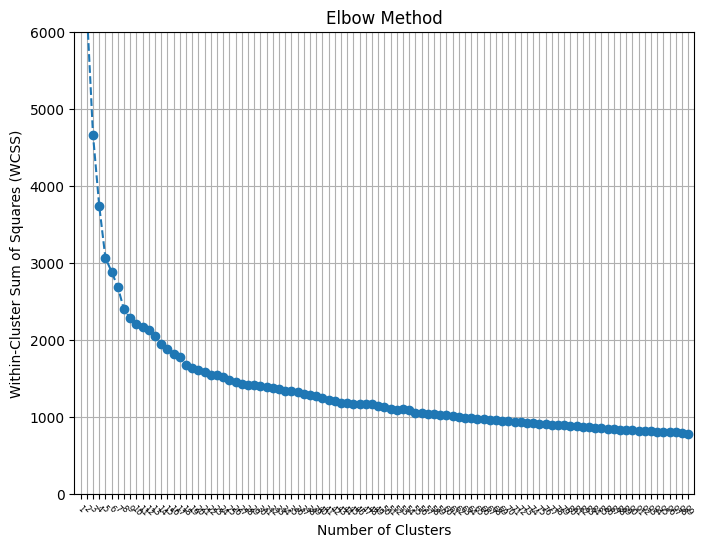

In [141]:
wcss = []

n =100

for k in range(1, n):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, n), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.ylim(0,6000)
plt.xlim(0,n)
plt.xticks(range(1, n),rotation=-45,size =6)
plt.grid(True)
plt.show()

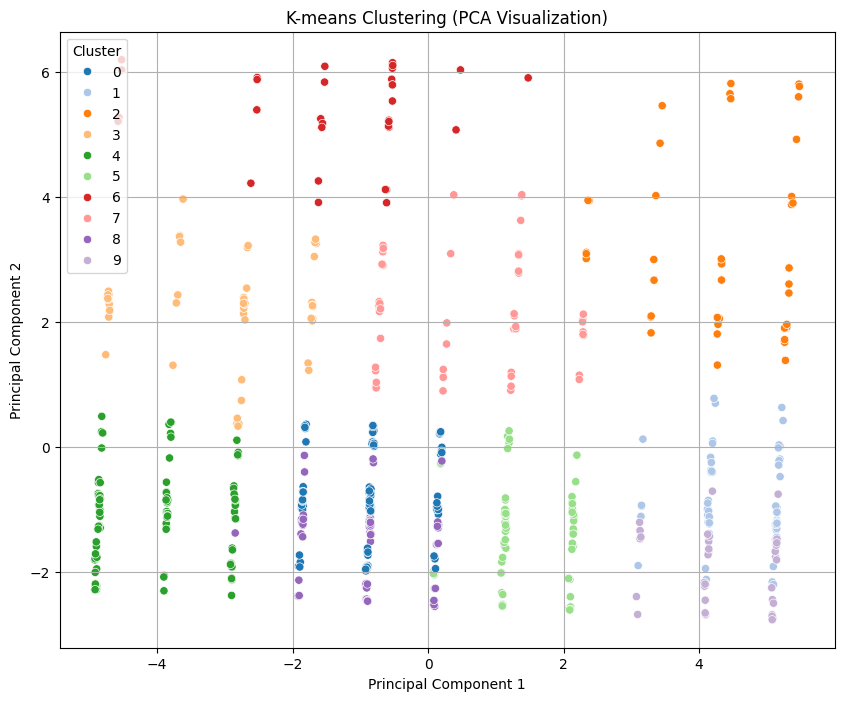

In [43]:
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(df) 

kmeans = KMeans(n_clusters=10, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(df)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],hue=clusters, palette='tab20', legend='full')
plt.title('K-means Clustering (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


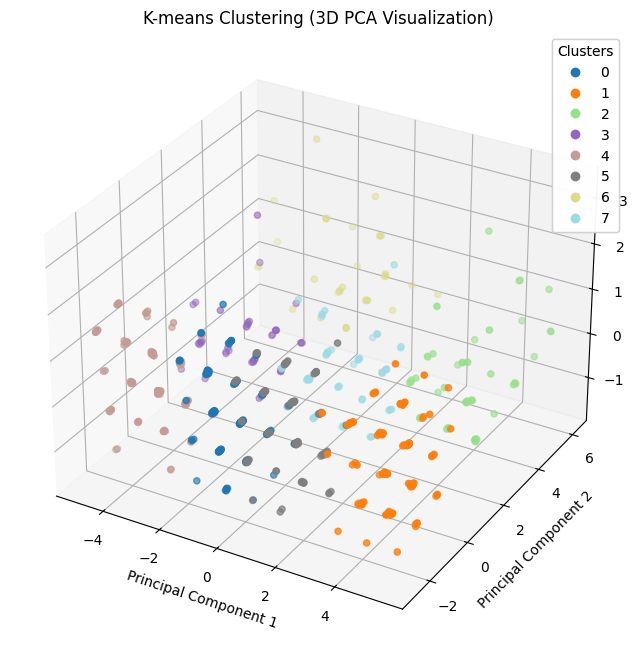

In [41]:
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  
X_pca = pca.fit_transform(df)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='tab20')

ax.set_title('K-means Clustering (3D PCA Visualization)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
legend1 = ax.legend(*scatter.legend_elements(), title='Clusters')
ax.add_artist(legend1)

plt.show()


In [138]:
df = pd.read_csv('../Data/spotify_modelling.csv')
df['cluster'] = clusters
df.loc[df.cluster==14,["artist(s)_name",'track_name','cluster']]

,artist(s)_name,track_name,cluster
16,Lil Nas X,MONTERO (Call Me By Your Name),14
39,The Weeknd,Save Your Tears,14
41,BoyWithUke,Toxic,14
43,Billie Eilish,Happier Than Ever,14
50,"Anuel Aa, Jhay Cortez",Ley Seca,14
82,Giveon,HEARTBREAK ANNIVERSARY,14
84,"J Balvin, Maria Becerra",Quï¿½ï¿½ Mï¿½ï¿,14
87,Rauw Alejandro,Cï¿½ï¿½,14
108,Shawn Mendes,It'll Be Okay,14
112,"Justin Bieber, Daniel Caesar, Giveon",Peaches (feat. Daniel Caesar & Giveon),14


## TODO
z lab9
- metoda łokcia
- metoda silhouette
inne opcjonalne:
- Indeks Dunna
- Indeks Daviesa–Bouldina
- Indeks Calińskiego-Harabasza znany jako Variance Ratio Criterion

### metryki interpretowalne - lab 9